In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
from torch.autograd import Variable
from PIL import Image
from PIL import ImageChops
from PIL import ImageEnhance
import torch.optim as optim
import tqdm
import copy
from loss import SegmentationLoss, ImageLoss
import random
from img_segm_img_model import ImageSegmentationImageModel
from eunet import EUnet

In [2]:
def process_dataset():
    file_names = sorted(glob.glob('./BBBC018/outlines/*'))
    file_numbers = []
    for file_name in file_names:
        if 'nuclei' in file_name:
            number = file_name.split('/')[-1]
            number = number.split('-')[0]
            if number not in file_numbers:
                file_numbers.append(number)

    file_numbers_train = file_numbers[:45]
    file_numbers_val = file_numbers[45:50]
    file_numbers_test = file_numbers[50:]

    for file_name in sorted(glob.glob('./BBBC018/images/*')):
        image = imageio.imread(file_name)
        name = file_name.split('_')[-1]
        number = name.split('-')[0]
        type_img = name.split('-')[1][:3]
        if type_img == 'DNA':
            type_img = 'nuclei.png'
        else:
            continue
        if number in file_numbers_train:
            imageio.imsave('./BBBC018_processed/images/train/{0}-{1}'.format(number, type_img), image)
        elif number in file_numbers_val:
            imageio.imsave('./BBBC018_processed/images/val/{0}-{1}'.format(number, type_img), image)
        else:
            imageio.imsave('./BBBC018_processed/images/test/{0}-{1}'.format(number, type_img), image)

    for file_name in sorted(glob.glob('./BBBC018/outlines/*')):
        segmentation = imageio.imread(file_name)
        name = file_name.split('/')[-1]
        number = name.split('-')[0]
        if 'nuclei' in name:
            if number in file_numbers_train:
                imageio.imsave('./BBBC018_processed/segmentation/train/{0}'.format(name), segmentation)
            elif number in file_numbers_val:
                imageio.imsave('./BBBC018_processed/segmentation/val/{0}'.format(name), segmentation)
            else:
                imageio.imsave('./BBBC018_processed/segmentation/test/{0}'.format(name), segmentation)

In [3]:
class SegmentationTransform(object):
    def __init__(self, train_trainsforms=True):
        self.train_trainsforms = train_trainsforms
        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize(size=(512, 512))
        
    def __call__(self, input_image, input_segmentation):
        
        image = transforms.ToPILImage()(input_image[:, :, 0].reshape(512, 512, 1))
        segmentation = transforms.ToPILImage()(input_segmentation.reshape(512, 512, 1))
        if self.train_trainsforms:
            if np.random.random() < 0.5:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
                segmentation = segmentation.transpose(Image.FLIP_TOP_BOTTOM)
            if np.random.random() < 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                segmentation = segmentation.transpose(Image.FLIP_LEFT_RIGHT)
            
            enhancer = ImageEnhance.Contrast(image)
            
            factor = np.random.uniform(low=0.3, high=2.0)
            image = enhancer.enhance(factor)
            
            enhancer = ImageEnhance.Brightness(image)
            
            factor = np.random.uniform(low=0.3, high=2.0)
            image = enhancer.enhance(factor)
            
            x_offset = np.random.randint(0, 256)
            y_offset = np.random.randint(0, 256)
            
            image = image.crop((x_offset, y_offset, x_offset + 256, y_offset + 256))
            segmentation = segmentation.crop((x_offset, y_offset, x_offset + 256, y_offset + 256))
            
        image_size = image.size
        image_blurred = image.resize((image_size[0]//8, image_size[1]//8), 
                                     Image.BILINEAR).resize(image_size, Image.BILINEAR)
        image_blurred_tensor = self.to_tensor(image_blurred)
        image_tensor = self.to_tensor(image)
        segmentation = np.array(segmentation)
        segmentation_tensor = np.zeros_like(segmentation)
        segmentation_tensor[segmentation != 0] = 1
        segmentation_tensor = torch.LongTensor(segmentation_tensor)
        return image_tensor, segmentation_tensor, image_blurred_tensor
#         plt.imshow(np.array(image), 'gray')
#         plt.show()
#         plt.imshow(np.array(segmentation), 'gray')
#         plt.show()
#         plt.imshow(np.array(image_blurred), 'gray')
#         plt.show()

In [4]:
im = imageio.imread('./BBBC018_processed/images/train/00733-nuclei.png')
mask = imageio.imread('./BBBC018_processed/segmentation/train/00733-nuclei.png')

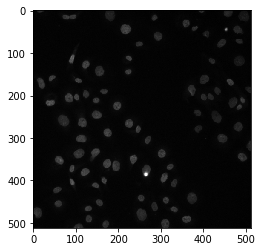

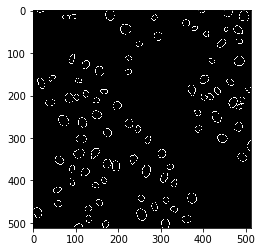

In [5]:
plt.imshow(im[:, :, 1], cmap='gray')
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, path_to_img, path_to_segmentation, transforms=None):
        if transforms:
            self.transforms = transforms
        else:
            self.transforms = None
        self.idx_to_files = {i: file_name.split('/')[-1]
                             for i, file_name in enumerate(sorted(glob.glob(path_to_img + '*')))}
        self.path_to_img = path_to_img
        self.path_to_segmentation = path_to_segmentation

    
    def __len__(self):
        return len(self.idx_to_files)
    
    def __getitem__(self, idx):
        image_name = self.path_to_img + self.idx_to_files[idx]
        segmentation_name = self.path_to_segmentation + self.idx_to_files[idx]
        im = imageio.imread(image_name)
        mask = imageio.imread(segmentation_name)
        if self.transforms:
            im, mask, blurred_im = self.transforms(im, mask)
            return im, mask, blurred_im
        return im, mask

In [7]:
def train_on_real_data(data_loader_train, data_loader_val, net, num_epoch, img_loss, segm_loss, num_segm=9):
    train_loss_history = [] 
    val_loss_history = []
    
    last_update = 0
    best_val_score = None
    best_model_params = None
    
    optimizer = optim.Adam(net.parameters())
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        
        net.train(True)
        i = 0 
        
        for image_batch, segmentation_batch, blurred_image_batch in data_loader_train:
            
            optimizer.zero_grad()
            image_batch = Variable(image_batch, requires_grad=False).cuda(0)
            segmentation_batch = Variable(segmentation_batch[:num_segm], requires_grad=False).cuda(0)
            blurred_image_batch = Variable(blurred_image_batch, requires_grad=False).cuda(0)
            
            generated_images, generated_segmentation = net.forward(image_batch, blurred_image_batch)

            train_loss = segm_loss(generated_segmentation[:num_segm], segmentation_batch)

            train_loss += 1000*img_loss(generated_images, image_batch)
            if i == 0:
                train_loss_history.append(train_loss.data[0])
                
            else:
                train_loss_history[-1] += train_loss.data[0]
            
            i += 1

            train_loss.backward()
            optimizer.step()
            
        train_loss_history[-1] /= i

        net.train(False)
        
        i = 0
        
        for image_batch, segmentation_batch, blurred_image_batch in data_loader_val:
            image_batch = Variable(image_batch, requires_grad=False).cuda(0)
            segmentation_batch = Variable(segmentation_batch, requires_grad=False).cuda(0)
            blurred_image_batch = Variable(blurred_image_batch, requires_grad=False).cuda(0)
            generated_val_images, generated_val_segmentation = net.forward(image_batch, blurred_image_batch)
            val_loss = segm_loss(generated_val_segmentation, segmentation_batch)
            val_loss += 1000*img_loss(generated_val_images, image_batch)
            if i == 0:
                val_loss_history.append(val_loss.data[0])
            else:
                val_loss_history[-1] += val_loss.data[0]
            i += 1
        
        val_loss_history[-1] /= i

        if best_val_score is None or best_val_score > val_loss_history[-1]:
            best_val_score = val_loss_history[-1]
            best_model_params = copy.deepcopy(net.state_dict())
            last_update = 0
        else:
            last_update += 1
    
    return train_loss_history, val_loss_history, best_model_params

In [8]:
segmentation_dataset_train = SegmentationDataset(path_to_img='./BBBC018_processed/images/train/', 
                                                 path_to_segmentation='./BBBC018_processed/segmentation/train/', 
                                                 transforms=SegmentationTransform())
data_loader_train = DataLoader(segmentation_dataset_train, batch_size=9, shuffle=False, num_workers=1)

segmentation_dataset_validation = SegmentationDataset(path_to_img='./BBBC018_processed/images/val/', 
                                                      path_to_segmentation='./BBBC018_processed/segmentation/val/', 
                                                      transforms=SegmentationTransform(False))
data_loader_val = DataLoader(segmentation_dataset_validation, batch_size=1, shuffle=False, num_workers=1)

segmentation_dataset_test = SegmentationDataset(path_to_img='./BBBC018_processed/images/test/', 
                                                path_to_segmentation='./BBBC018_processed/segmentation/test/', 
                                                transforms=SegmentationTransform(False))
data_loader_test = DataLoader(segmentation_dataset_test, batch_size=1, shuffle=False, num_workers=1)

In [9]:
net = ImageSegmentationImageModel(input_dim=1, num_classes=2, batch_norm=True, blurred_image=True).cuda(0)
starting_parameters = copy.deepcopy(net.state_dict())
segm_loss = SegmentationLoss(weight=torch.FloatTensor(np.array([1.0, 5.0])).cuda(0))
img_loss = ImageLoss()

In [ ]:
# for num_segm in [1, 5, 9]:
#     net.load_state_dict(starting_parameters)
#     train, val, params = train_on_real_data(data_loader_train, data_loader_val, net, 20000, 
#                                             img_loss, segm_loss, num_segm=num_segm)
#     torch.save(params, 'segm_img_model_{}'.format(num_segm))

#     np.save('segm_img_model_train_loss_{}'.format(num_segm), np.array(train))
#     np.save('segm_img_model_val_loss_{}'.format(num_segm), np.array(val))

#     torch.save(net.state_dict(), 'segm_img_model_last_params_{}'.format(num_segm))    

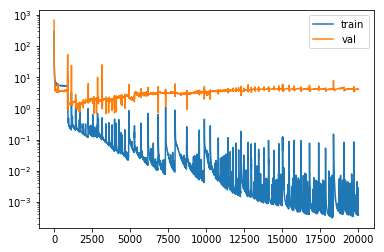

In [10]:
train_loss = np.load('./segm_img_model_train_loss.npy')
val_loss = np.load('./segm_img_model_val_loss.npy')

plt.semilogy(train_loss, label='train')
plt.semilogy(val_loss, label='val')
plt.legend()
plt.show()

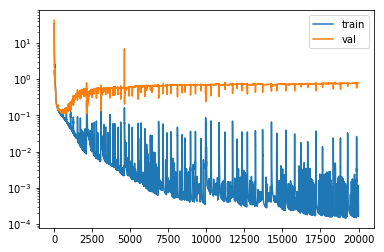

In [10]:
train_loss = np.load('./segm_img_model_train_loss_100.npy')
val_loss = np.load('./segm_img_model_val_loss_100.npy')

plt.semilogy(train_loss, label='train')
plt.semilogy(val_loss, label='val')
plt.legend()
plt.show()

### Image loss weight = 1000

In [19]:
net.load_state_dict(torch.load('./segm_img_model_last_params'))

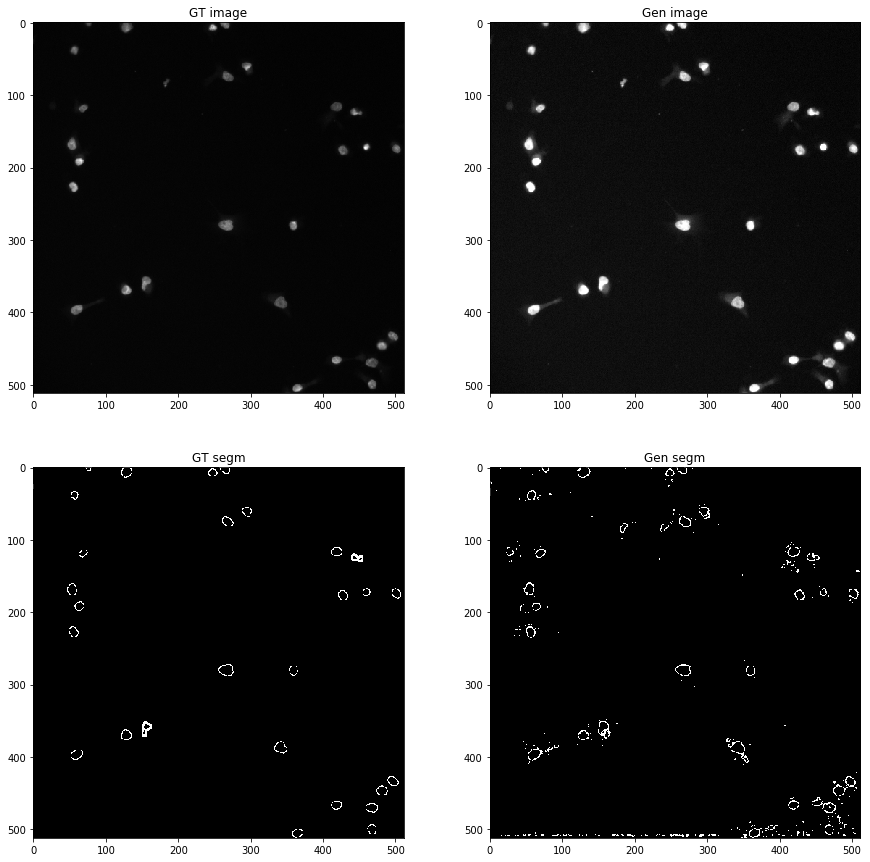

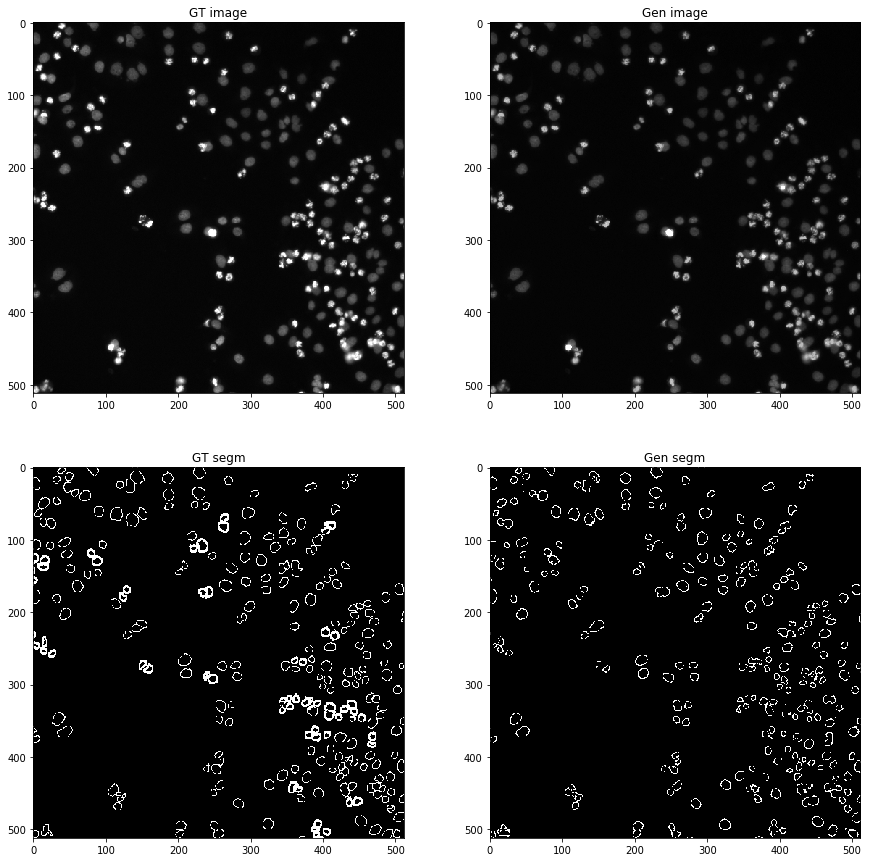

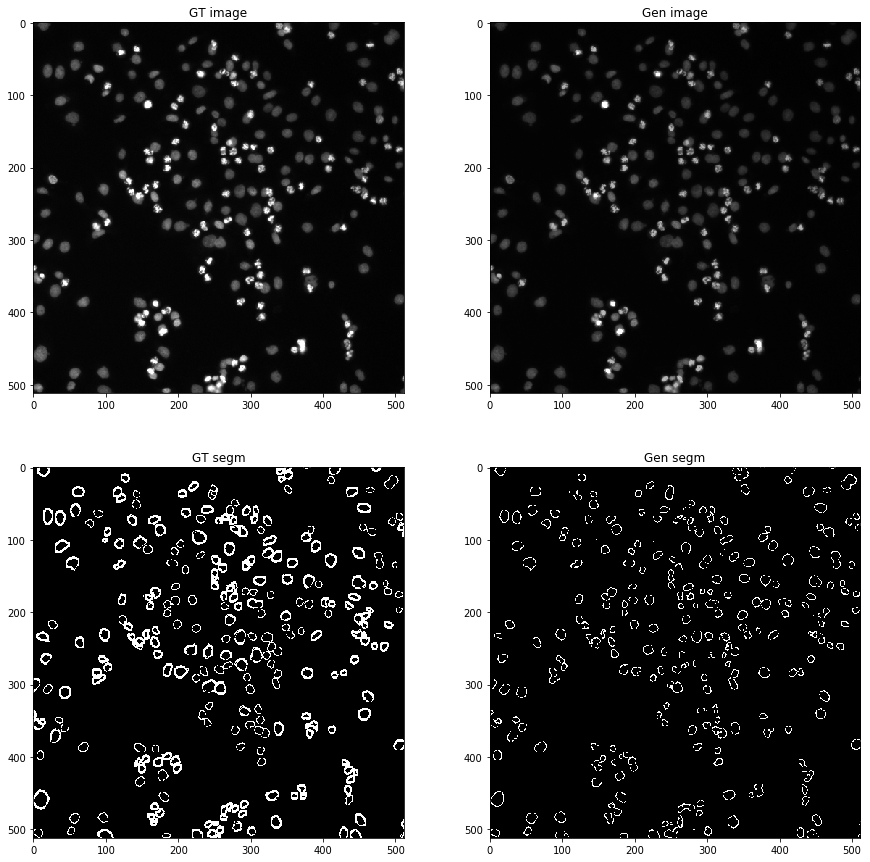

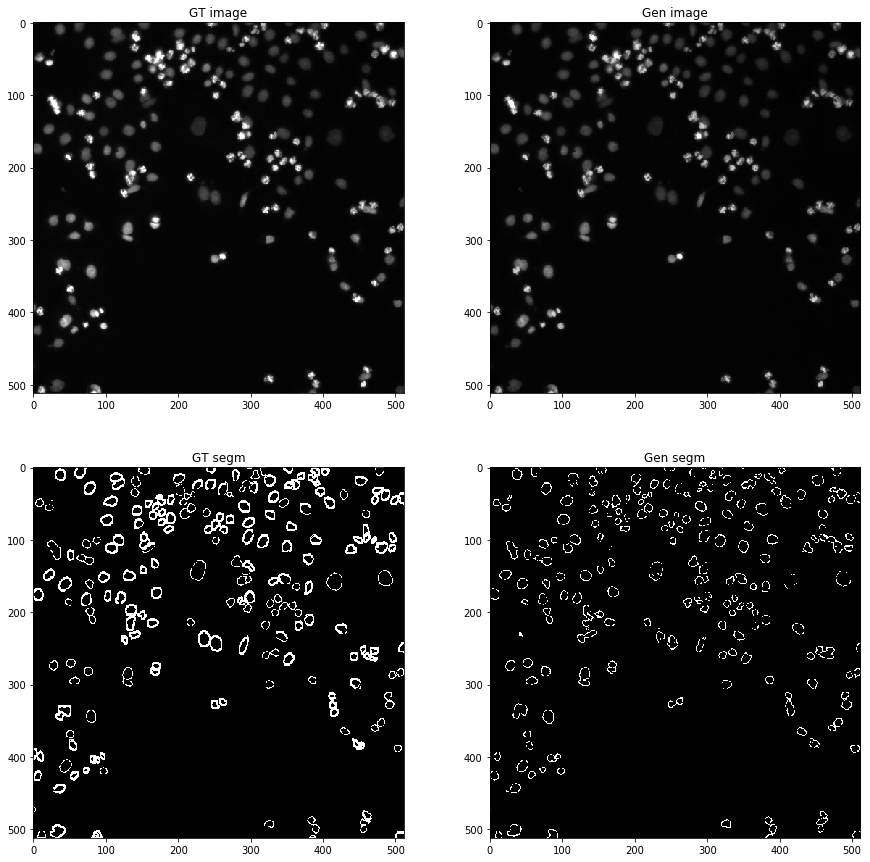

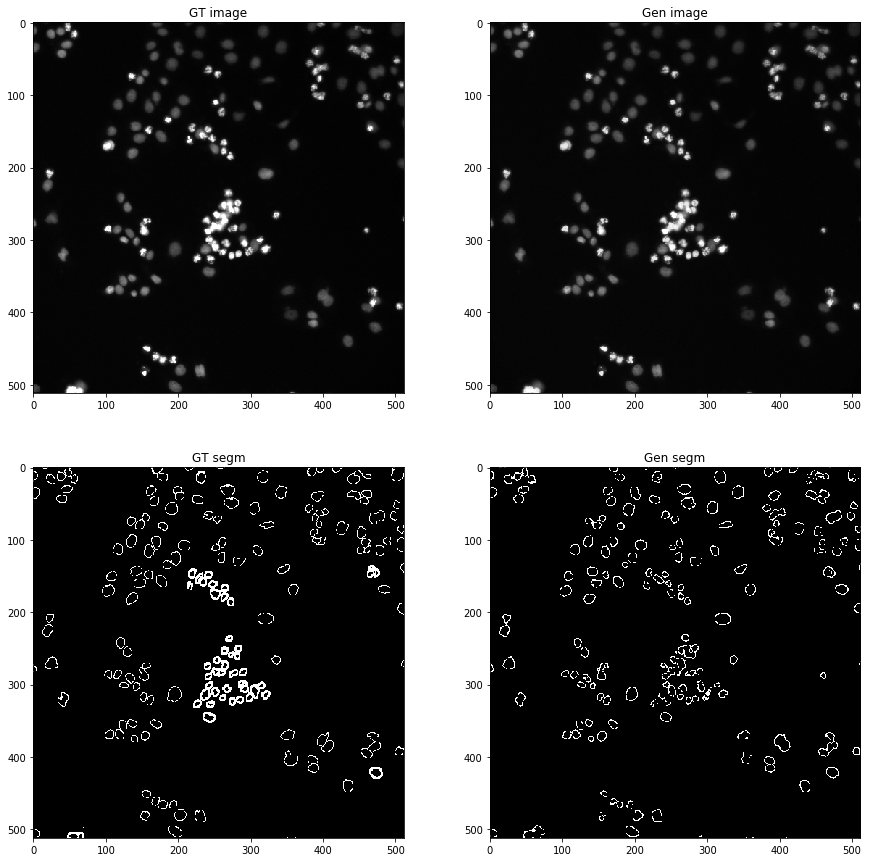

In [20]:
for image, segmentation, blurred_image in data_loader_test:
    image = Variable(image.cuda(0), requires_grad=False)
    blurred_image = Variable(blurred_image.cuda(0), requires_grad=False)
    generated_image, generated_segmentation = net.forward(image, blurred_image)
    f, ax = plt.subplots(2, 2, figsize=(15, 15))
    ax[0, 0].imshow(image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 0].set_title('GT image')
    ax[0, 1].imshow(generated_image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 1].set_title('Gen image')
    ax[1, 0].imshow(segmentation.numpy()[0], cmap='gray')
    ax[1, 0].set_title('GT segm')
    ax[1, 1].imshow(np.argmax(generated_segmentation.cpu().data.numpy()[0], axis=0), cmap='gray')
    ax[1, 1].set_title('Gen segm')

### Image loss weight = 100

In [10]:
net.load_state_dict(torch.load('./segm_img_model_last_params_100'))

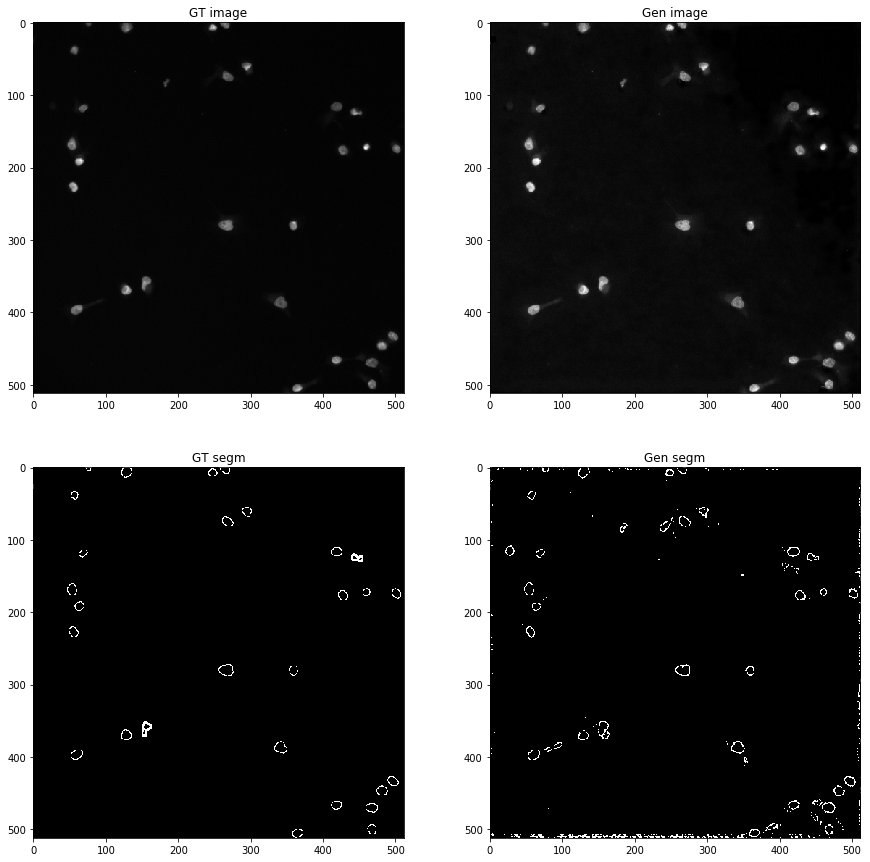

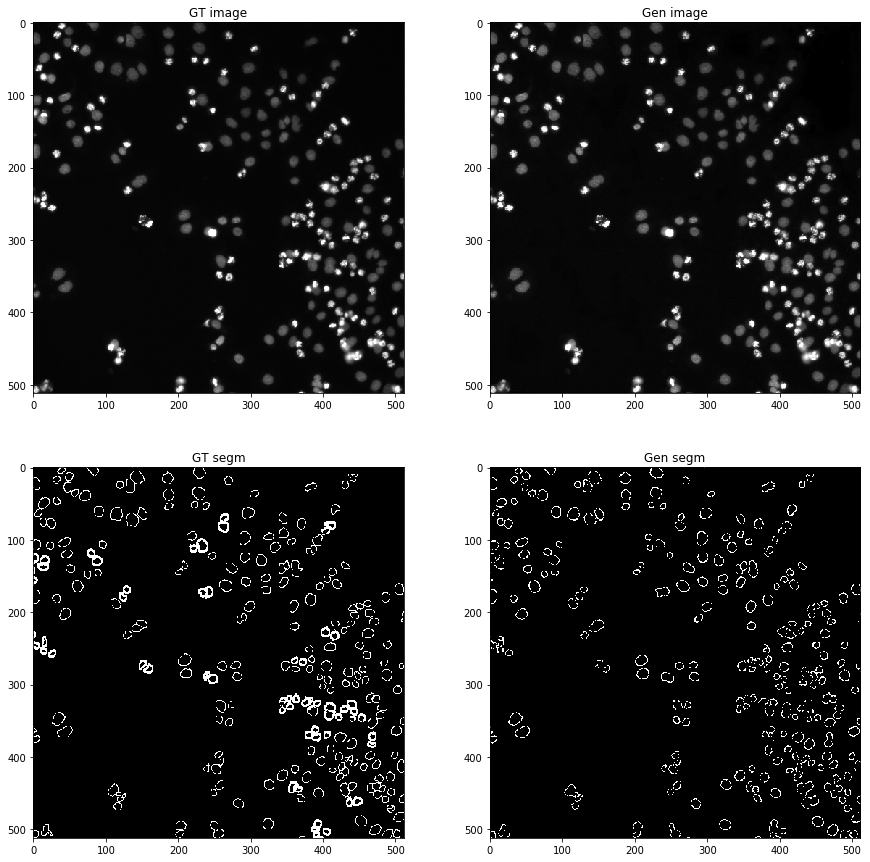

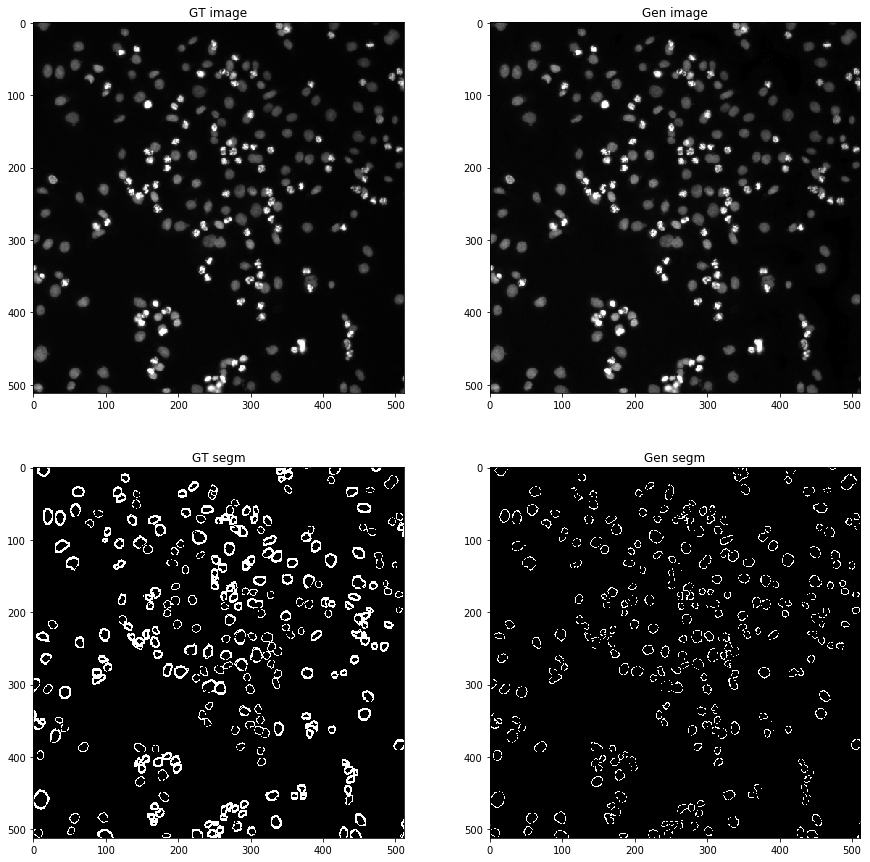

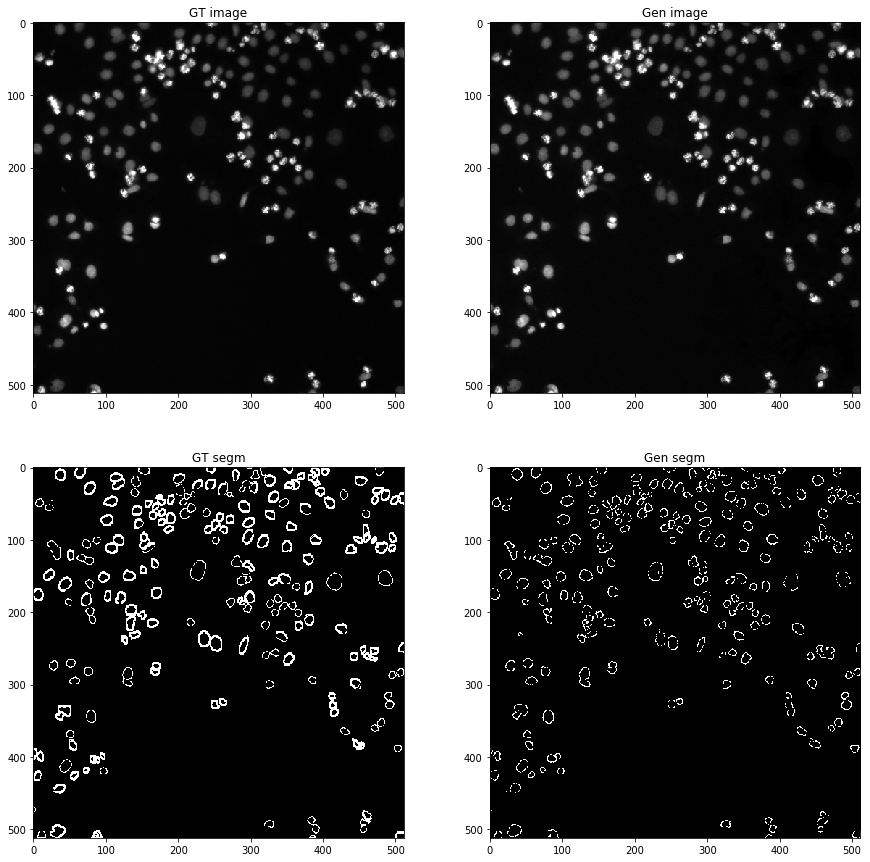

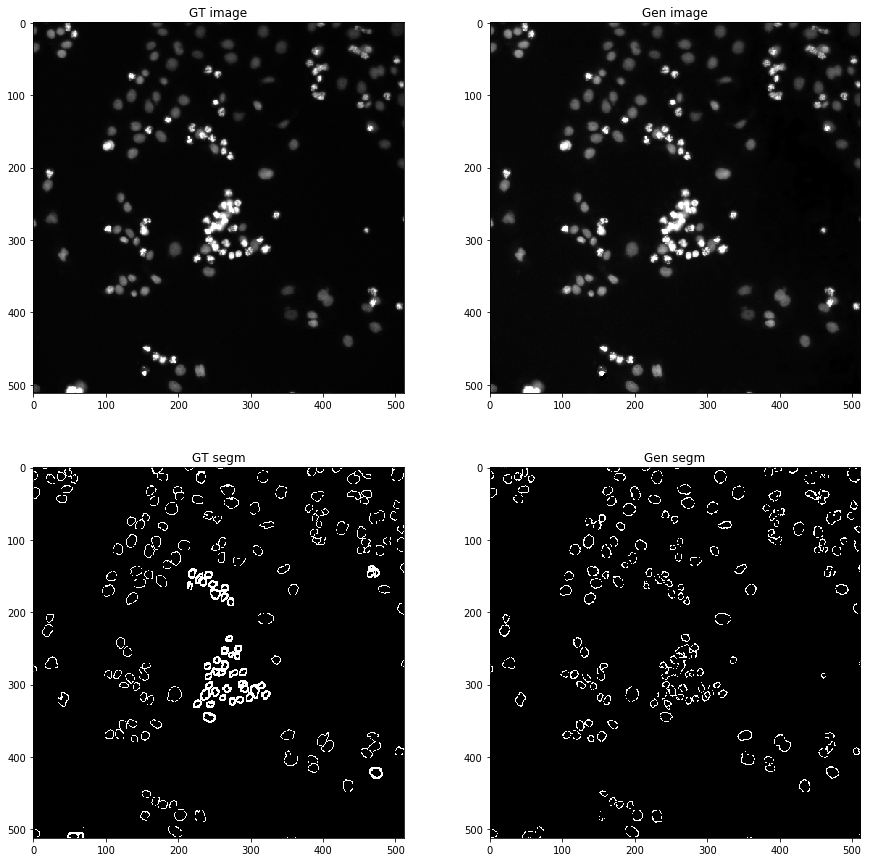

In [11]:
for image, segmentation, blurred_image in data_loader_test:
    image = Variable(image.cuda(0), requires_grad=False)
    blurred_image = Variable(blurred_image.cuda(0), requires_grad=False)
    generated_image, generated_segmentation = net.forward(image, blurred_image)
    f, ax = plt.subplots(2, 2, figsize=(15, 15))
    ax[0, 0].imshow(image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 0].set_title('GT image')
    ax[0, 1].imshow(generated_image.cpu().data.numpy()[0][0], cmap='gray')
    ax[0, 1].set_title('Gen image')
    ax[1, 0].imshow(segmentation.numpy()[0], cmap='gray')
    ax[1, 0].set_title('GT segm')
    ax[1, 1].imshow(np.argmax(generated_segmentation.cpu().data.numpy()[0], axis=0), cmap='gray')
    ax[1, 1].set_title('Gen segm')